In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

In [2]:
# functions
def get_intersecting_genes(data_frame, by: str = 'iteration'):
    iterations = data_frame.iteration.drop_duplicates().values
    df_intersecting = data_frame.loc[data_frame.iteration == iterations[0], ["gene"]]
    for i in range(1, len(iterations)):
        df_temp = data_frame.loc[data_frame.iteration == iterations[i], ["gene"]]
        df_intersecting = df_intersecting.merge(df_temp, how='inner', on="gene")
        
    return df_intersecting.sort_values(by="gene").gene.drop_duplicates().values

def get_consensus_matrix_one_iteration(data_frame, by: str = 'cluster_all'):
    unique_genes = data_frame.gene.drop_duplicates().values

    genes_clusters = data_frame[['gene', by]].drop_duplicates()

    clusters = genes_clusters[by].values

    consensus_matrix = np.zeros((len(unique_genes), len(unique_genes)))

    for i in range(len(unique_genes)):
        gene = unique_genes[i]
        if len(data_frame[data_frame.gene == gene][by].values)>1:
            print('SOMETHING BAD HAPPENED')
        cluster_all_label = data_frame[data_frame.gene == gene][by].values[0]
        location = np.where(clusters == cluster_all_label)[0]
        if len(location) > 0:
            consensus_matrix[i, location] += 1

    return consensus_matrix

def get_consensus_matrix(data_frame, genes_to_consider, by):
    
    df = data_frame[data_frame.gene.isin(genes_to_consider)].copy()
    
    iterations = df.iteration.drop_duplicates().values
    
    consensus_matrix = np.zeros((len(genes_to_consider), len(genes_to_consider)))
    for i in iterations:
        df_temp = df[df.iteration==i].sort_values(by='gene')
        
        consensus_matrix += get_consensus_matrix_one_iteration(df_temp, by)
        
    return consensus_matrix/len(iterations)

def get_consensus_probs_one_iteration(data_frame, genes_to_consider, regulators_to_consider):
    
    unique_genes = genes_to_consider
    
    unique_regulators = regulators_to_consider
    
    consensus_matrix = np.zeros((len(unique_genes), len(unique_regulators)))
    
    for i in range(len(unique_genes)):
        gene = unique_genes[i]
        
        regulators = data_frame[data_frame.gene == gene]["regulators"].values
        locations = np.where(np.isin(unique_regulators, regulators))[0]
        if len(locations) > 0:
            consensus_matrix[i, locations] += 1

    return consensus_matrix
    
def get_regulator_consensus_matrix(data_frame, genes_to_consider, regulators_to_consider):
    
    df = data_frame[data_frame.gene.isin(genes_to_consider) & data_frame.regulators.isin(regulators_to_consider)].copy()
    
    iterations = df.iteration.drop_duplicates().values
    
    consensus_matrix = np.zeros((len(genes_to_consider), len(regulators_to_consider)))
    for i in iterations:
        df_temp = df[df.iteration==i].sort_values(by='gene')
        
        consensus_matrix += get_consensus_probs_one_iteration(df_temp, genes_to_consider, regulators_to_consider)
        
        print(i)
        
    return consensus_matrix/len(iterations)

def get_all_iterations_penalty(path, penalty: str):
    files = [f for f in os.listdir(path) if penalty in f]
    
    df = None
    for file in files:
        df_temp = pd.read_csv(f'{path}/{file}')
        df = pd.concat([df,df_temp])
    return df
 

In [ ]:
# modes

path = 'benchmark_models_csv'

penalties = ['0.1', '0.2', '0.3', '0.4', '0.5']

df = None
for penalty in penalties:

    all_data = get_all_iterations_penalty(path, penalty=penalty)[['iteration', 'penalty', 'state']].drop_duplicates()
    
    df_temp = pd.pivot_table(all_data, index= ['iteration', 'penalty'], aggfunc={'state':max}).reset_index()
    
    df = pd.concat([df, df_temp])


plt.figure(figsize=(6,6))
plt.title('Modes', fontsize=18)
ax = plt.subplot(111)

sns.boxplot(df, x='penalty', y='state')
plt.ylim(-1,11)
plt.xlabel('Penalty', fontsize=12)
plt.ylabel('Modes', fontsize=12)

In [ ]:
# rag bag %

path = 'benchmark_models_csv'

penalties = ['0.1', '0.2', '0.3', '0.4', '0.5']

df_resp = None
for penalty in penalties:

    all_data = get_all_iterations_penalty(path, penalty=penalty).sort_values(by='iteration', ascending=True)
    
    # non-regulators + 1 random final configuration
    df = all_data.loc[(all_data.is_regulator == False), ["iteration", "penalty", "gene", "cluster"]].drop_duplicates()
    
    df.loc[:, 'rag_bag'] = df.cluster.apply(lambda x: 1 if x==-1 else 0)
    
    df_agg = pd.pivot_table(df, index=['iteration', "penalty"], aggfunc={'rag_bag':sum, 'gene':'count'}).reset_index()
    
    df_agg.loc[:,"rag_perc"] = df_agg.rag_bag/df_agg.gene
    
    df_resp = pd.concat([df_resp, df_agg])
    
plt.figure(figsize=(6,6))
plt.title('% rag bag', fontsize=18)
ax = plt.subplot(111)

sns.boxplot(df_resp, x='penalty', y='rag_perc')
plt.xlabel('Penalty', fontsize=12)
plt.ylabel('% rag bag', fontsize=12)
    

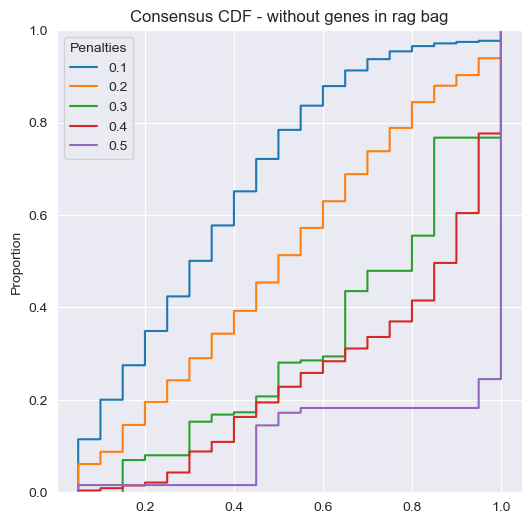

In [40]:
# cluster consensus

path = 'benchmark_models_csv'

penalties = ['0.1', '0.2', '0.3', '0.4', '0.5']

plt.figure(figsize=(6,6))
plt.title('Consensus CDF - without genes in rag bag')
ax = plt.subplot(111)

for penalty in penalties:

    all_data = get_all_iterations_penalty(path, penalty=penalty).sort_values(by='iteration', ascending=True)
    
    # non-regulators + 1 random final configuration + non-rag_bag
    df = all_data.loc[(all_data.state == 1) & (all_data.is_regulator == False) & (all_data.cluster != -1) , ["iteration", "gene", "cluster"]].drop_duplicates()
    
    intersecting_genes = get_intersecting_genes(df, 'iteration')
    
    cmatrix = get_consensus_matrix(df[df.gene.isin(intersecting_genes)],
                                   intersecting_genes,
                                   'cluster')

    upper_triangle = np.triu(cmatrix, k=1)
    upper_triangle = upper_triangle[upper_triangle != 0]
    
    sns.ecdfplot(upper_triangle, 
                 ax=ax,
                 legend=penalty)
plt.legend(labels=penalties, 
           title='Penalties')
plt.show()


0.1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0.2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0.3
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0.4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0.5
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


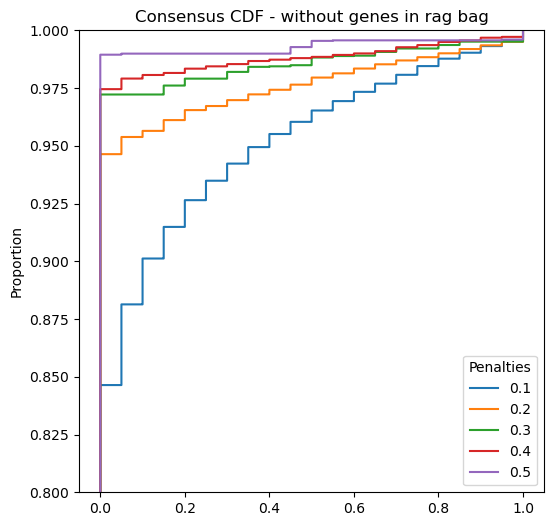

In [4]:
# regulator consensus

path = 'benchmark_models_csv'

penalties = ['0.1', '0.2', '0.3', '0.4', '0.5']

plt.figure(figsize=(6,6))
plt.title('Consensus CDF - without genes in rag bag')
ax = plt.subplot(111)

for penalty in penalties:
    print(penalty)

    all_data = get_all_iterations_penalty(path, penalty=penalty).sort_values(by='iteration', ascending=True)    
    
    # no rag bags + 1 random final configuration
    df = all_data.loc[(all_data.state==1) & (all_data.cluster!=-1),  ["iteration", "gene", "regulators"]].drop_duplicates()

    
    unique_regulators = get_intersecting_genes(all_data.loc[all_data.is_regulator,  ["iteration", "gene"]].drop_duplicates(), 
                                               by = 'iteration')
    
    unique_genes = get_intersecting_genes(all_data.loc[(all_data.is_regulator == False) & (all_data.cluster!=-1), ["iteration", "gene"]].drop_duplicates(), 
                                          by = 'iteration')
    
    cmatrix = get_regulator_consensus_matrix(df, 
                                             unique_genes, 
                                             unique_regulators)
    
    sns.ecdfplot(cmatrix.flatten(), 
                 ax=ax,
                 legend=penalty)
plt.legend(labels=penalties, 
           title='Penalties')
plt.ylim(0.8,1)
plt.show()
